# IDS classification using NSL-KDD dataset

Released by Théophane Dumas and Cyrille Tryer

### Goal

The goal of this project was to compare two classification models that can be used by an Intrusion Detection System.

### Dataset

We use the well known NSL-KDD model.

### References

This report is inspired from this work : [https://github.com/thinline72/nsl-kdd](https://github.com/thinline72/nsl-kdd)

# Data processing

First we connect to Spark, and we load the dataset.

This dataset contains 41 features like protocol_type or service. These feature describe a network connexion, a label is associated to the connexion like normal, apache2 or satan.

In [1]:
import pyspark
import numpy as np
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, udf
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql

context = SparkSession.builder.appName('projet').getOrCreate().sparkContext

In [2]:
# Function to load dataset and divide it into 8 partitions
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

def load_dataset(path):
    dataset_rdd = context.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType())))

    return dataset_df

In [3]:
train = load_dataset('kdd/KDDTrain+.txt')
test = load_dataset('kdd/KDDTest+.txt')

In [4]:
print('number of lines loaded :', train.count() + test.count())

number of lines loaded : 148517


In [5]:
print('# Top 10 labels :')
train.groupBy('labels').count().sort('count', ascending=False).limit(10).show()

# Top 10 labels :
+-----------+-----+
|     labels|count|
+-----------+-----+
|     normal|67343|
|    neptune|41214|
|      satan| 3633|
|    ipsweep| 3599|
|  portsweep| 2931|
|      smurf| 2646|
|       nmap| 1493|
|       back|  956|
|   teardrop|  892|
|warezclient|  890|
+-----------+-----+



In [6]:
print('# Top 10 services :')
train.groupBy('service').count().sort('count', ascending=False).limit(10).show()

# Top 10 services :
+--------+-----+
| service|count|
+--------+-----+
|    http|40338|
| private|21853|
|domain_u| 9043|
|    smtp| 7313|
|ftp_data| 6860|
|   eco_i| 4586|
|   other| 4359|
|   ecr_i| 3077|
|  telnet| 2353|
|  finger| 1767|
+--------+-----+



# Pipeline definition

We define a pipeline to format train & test datasets for classification models.

In [7]:
from pyspark.ml import Pipeline, Transformer
from pyspark import keyword_only

# We simplify class like in https://github.com/thinline72/nsl-kdd.

attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'scan',
    'nmap': 'scan',
    'portsweep': 'scan',
    'satan': 'scan',
    'mscan': 'scan',
    'saint': 'scan',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'privesc',
    'loadmodule': 'privesc',
    'perl': 'privesc',
    'rootkit': 'privesc',
    'httptunnel': 'privesc',
    'ps': 'privesc',    
    'sqlattack': 'privesc',
    'xterm': 'privesc'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

train = train.withColumn('labels5', attack_mapping_udf(train['labels']))
test = test.withColumn('labels5', attack_mapping_udf(test['labels']))

In [8]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, UnivariateFeatureSelector, VarianceThresholdSelector
from pyspark.ml import Pipeline

stages = []

feature_names = []

for col in test.schema :
    if str(col.dataType) == 'StringType':
        try:
            si = StringIndexer(inputCol = col.name, outputCol = col.name + '_idx')
            stages += [si]
            feature_names += [col.name + '_idx']
        except:
            pass

feature_names += [col.name for col in train.schema if col.name not in ["labels", "protocol_type", "service", "flag"] and str(col.dataType) == 'DoubleType' ]
feature_names.remove('labels5_idx')
print(feature_names)

assembler = VectorAssembler(outputCol="features", inputCols=feature_names)

stages += [assembler]

normalizer = StandardScaler(inputCol="features", outputCol="normFeatures")
stages += [normalizer]

selector = UnivariateFeatureSelector(featuresCol="normFeatures", outputCol="selectedFeatures",
                                     labelCol="labels5_idx", selectionMode="numTopFeatures")
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(10)
# selector = VarianceThresholdSelector(varianceThreshold=0.1, outputCol="selectedFeatures", featuresCol="normFeatures")
# old one was 0.2
stages += [selector]

pipeline = Pipeline(stages=stages)

['protocol_type_idx', 'service_idx', 'flag_idx', 'labels_idx', 'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


Then we use pipeline to transform datasets 

In [9]:
# prepare data
train_data = pipeline.fit(train).transform(train)
train_data = train_data.withColumnRenamed("labels_idx", "label")
train_data = train_data.drop("features")
train_data = train_data.withColumnRenamed("selectedFeatures", "features")

test_data = pipeline.fit(test).transform(test)
test_data = test_data.withColumnRenamed("labels_idx", "label")
test_data = test_data.drop("features")
test_data = test_data.withColumnRenamed("selectedFeatures", "features")

# train_data.select('normFeatures').limit(1).show(truncate=False)

In [10]:
train_data.select('features').limit(1).toPandas()

,features
0,"(0.0, 0.3364698152787053, 0.0, 0.0, 0.0, 0.0, ..."


# Prediction with NaiveBayes model

In [11]:
# Naives Bayes
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
naive_bayes_model = nb.fit(train_data)

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = naive_bayes_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
naive_bayes_accuracy = evaluator.evaluate(predictions)

print('First 10 predictions : ')
predictions.limit(10).select("label", "prediction", "probability").show()

print('accuracy in test dataset :', naive_bayes_accuracy)

First 10 predictions : 
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       1.0|[0.02015479803007...|
|  1.0|       1.0|[0.02015479803007...|
|  0.0|       1.0|[0.31790218781455...|
| 11.0|       5.0|[2.56200448974404...|
|  3.0|       1.0|[5.59283618338924...|
|  0.0|       0.0|[0.96335851943539...|
|  0.0|       0.0|[0.99901550276848...|
|  2.0|      11.0|[4.37636473286757...|
|  0.0|       0.0|[0.99569162698957...|
|  2.0|      11.0|[1.39622670385850...|
+-----+----------+--------------------+

accuracy in test dataset : 0.9306079252302235


# Prediction with LogisticRegression model

In [13]:
# multinomial logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8)


logic_reg = lr.fit(train_data)

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = logic_reg.transform(test_data)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
logistic_reg_accuracy = evaluator.evaluate(predictions)

print('First 10 predictions : ')
predictions.limit(10).select("label", "prediction", "probability").show()

print('accuracy in test dataset :', logistic_reg_accuracy)

First 10 predictions : 
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       0.0|[0.47990642848867...|
|  1.0|       0.0|[0.47990642848867...|
|  0.0|       0.0|[0.48620687209608...|
| 11.0|       0.0|[0.41757690374265...|
|  3.0|       0.0|[0.46732668598615...|
|  0.0|       0.0|[0.64218678280572...|
|  0.0|       0.0|[0.64218678280572...|
|  2.0|       0.0|[0.47361236973570...|
|  0.0|       0.0|[0.64218678280572...|
|  2.0|       0.0|[0.47361236973570...|
+-----+----------+--------------------+

accuracy in test dataset : 0.5311696407698902


# Random forest classifier

In [15]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(numTrees=4)
random_forest_model = rfc.fit(train_data)

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = random_forest_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
random_forest_accuracy = evaluator.evaluate(predictions)

print('First 10 predictions : ')
predictions.limit(20).select("label", "prediction", "probability").show()

print('accuracy in test dataset :', random_forest_accuracy)

First 10 predictions : 
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       0.0|[1.0,0.0,0.0,0.0,...|
|  1.0|       0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,...|
| 11.0|       5.0|[0.0,0.0,0.128571...|
|  3.0|       2.0|[0.0,0.4448665880...|
|  0.0|       0.0|[0.99688548423171...|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,...|
|  2.0|       2.0|[0.24923234390992...|
|  0.0|       0.0|[0.99688548423171...|
|  2.0|       2.0|[0.0,0.2499999999...|
|  3.0|       2.0|[0.24923234390992...|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,...|
|  1.0|       0.0|[1.0,0.0,0.0,0.0,...|
|  1.0|       0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|       0.0|[0.98500967117988...|
|  0.0|       0.0|[0.99688548423171...|
|  0.0|       0.0|[0.99688548423171...|
|  0.0|       0.0|[0.99688548423171...|
|  0.0|       0.0|[0.82526636225266...|
|  1.0|       0.0|[1.0,0.0,0.0,0.0,...|
+-----+----------+--------------------+

accuracy in tes

# Conclusion


The most effective model is Naive Bayes. with an accuracy of 0.9306079252302235


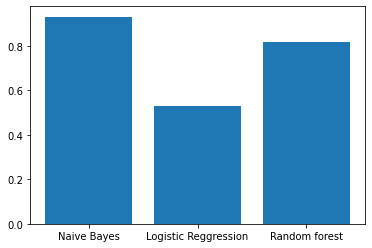

In [17]:
from matplotlib import pyplot as plt

x =  ['Naive Bayes', 'Logistic Reggression', 'Random forest']
y = [naive_bayes_accuracy, logistic_reg_accuracy, random_forest_accuracy]

plt.bar(x, y)

acc_max = x[y.index(max(y))]
print('\nThe most effective model is %s. with an accuracy of %s' % (acc_max, max(y)))